# Dashboard

This notebook provides and demonstrates frameworks to ingest tables (as dataframes, either from local or online sources) and help the user quickly find out (through visualizations):

- What data is available/missing?
    - Provide number of facts
    - Provide number of missing facts
- How good are precision and recall?
    - Given some ground truth (from local or online sources), calculate precision and recall
- Are quantities reasonable?
    - Statistical quality measures of errors
        - Are ages negative?
        - Are names unreasonably long?

In [116]:
import io, nltk, requests
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from htmldate import find_date
from matplotlib.lines import Line2D
from os import listdir
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu

# Functions

In [2]:
'''
Prints the table's number of rows, number of columns, and names of columns
Inputs:
    - dataframe df, containing the table to assess
'''
def summarize_rows_columns(df):
    num_rows = len(df)
    num_columns = len(df.columns)
    column_names = df.columns

    print('num_rows: %s' % num_rows)
    print('num_columns: %s' % num_columns)
    print('column_names: %s' % list(column_names))

In [9]:
'''
Visualizes the amount of facts present in and missing from the table.
Inputs:
    - dataframe df, containing the table to assess
    - string count_or_fraction (default value is 'count') indicating whether to plot count or fraction
'''
def plot_present_missing(df, count_or_fraction='count'):
    count_present = {}
    count_missing = {}
    column_names = df.columns
    for column_name in column_names:
        temp = df[column_name].isna().sum()
        count_missing[column_name] = temp
        count_present[column_name] = len(df[column_name]) - temp

    plt.figure(figsize=(12,4), dpi=150)
    # set width of bar
    barWidth = 0.25

    if count_or_fraction=='count':
        # set height of bar
        bars1 = list(count_present.values())
        bars2 = list(count_missing.values())
        title = 'Count Facts Present and Missing per Column'
        ylabel = 'Count'
    else:
        # set height of bar
        bars1 = [x/len(df) for x in count_present.values()]
        bars2 = [x/len(df) for x in count_missing.values()]
        title = 'Fraction of Facts Present and Missing per Column'
        ylabel = 'Fraction'

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, bars1, color='xkcd:sky blue', width=barWidth, edgecolor='white', label='Facts Present')
    plt.bar(r2, bars2, color='xkcd:gray', width=barWidth, edgecolor='white', label='Facts Missing')

    # Add xticks on the middle of the group bars
    plt.xlabel('Column Name', fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([r + barWidth*0.5 for r in range(len(bars1))], list(count_present.keys()), rotation=45)
    
    if count_or_fraction=='fraction':
        plt.yticks(np.arange(0, 1.1, 0.1))

    plt.title(title, fontweight='bold')
    plt.legend(loc='lower right')
    plt.show()

In [200]:
'''
What fraction of the df1 is also in df2?
'''
def _get_fraction(df_1, df_2, col_1, col_2, jaccard_thresh):
    count_matches = 0
    for test_ind in df_1.index:
        match_exists = False
        test_val = df_1[col_1][test_ind]
        try:
            test_chars = set(nltk.ngrams(test_val, n=3))
        except:
            continue # skip this cell if NaN i.e. value not available
        for ind in df_2.index:
            gt_val = df_2[col_2][ind]
            try:
                gt_chars = set(nltk.ngrams(gt_val, n=3))
            except:
                continue # skip this cell if NaN i.e. value not available
            jd = nltk.jaccard_distance(test_chars, gt_chars)

            # if the jaccard index does not exceed the threshold
            if jd <= jaccard_thresh:
                match_exists = True
        if match_exists:
            count_matches +=1
    fraction = count_matches/len(df_1)
    return fraction

In [202]:
'''
Inputs:
- df_test dataframe with test data
- df_gt dataframe with gt data
- col_test string name of column with data in df_test
- col_gt string name of column with data in gt_test
- jaccard_thresh float Jaccard distance threshold for correctness

See `demo_find_jaccard_distance_threshold.ipynb` for demo of
getting Otsu, k-means, and manually-determined thresholds
and visualizations of the distribution of Jaccard distances
with the k-means, otsu, and manually determined thresholds.

Output:
- Precision: the fraction of the test data that is also in the ground truth
- Recall: fraction of the ground truth that is also in the test data
'''
def get_precision(df_test, df_gt, col_test, col_gt, jaccard_thresh):
    return _get_fraction(df_test, df_gt, col_test, col_gt, jaccard_thresh)

def get_recall(df_test, df_gt, col_test, col_gt, jaccard_thresh):
    return _get_fraction(df_gt, df_test, col_gt, col_test, jaccard_thresh)

# Demo 1: Michigan Secretary of State Offices

## Data source

Table of values collected using my version of an API that queries and scrapes from YellowPages.com.
- Scraping takes place in ./yellowpages/yellowpages_api_get_more_pages.ipynb
- The API lives at ./yellowpages/collect.py

#### Load data table

(Of course, this table could also be created right here using the Yellow Pages scraping API, but I'm going to load it from storage since scraping has aready happened.)

In [10]:
df_misos = pd.read_csv('./yellowpages/state+of+michigan+secretary+of+state+office-MI-yellowpages-scraped-data.csv')

In [11]:
df_misos.head()

,rank,business_name,telephone,business_page,category,website,rating,street,locality,region,zipcode,listing_url
0,1.0,Michigan Secretary Of State Branch Office,(888) 767-6424,https://www.yellowpages.com/sparta-mi/mip/mich...,State Government,http://www.michigan.gov,2.0,534 S State St,Sparta,MI,49345,https://www.yellowpages.com/search?search_term...
1,2.0,State of Michigan Secretary of State Branch Of...,(888) 767-6424,https://www.yellowpages.com/adrian-mi/mip/stat...,State Government,http://expresssos.com,NaN,1040 S Winter St,Adrian,MI,49221,https://www.yellowpages.com/search?search_term...
2,3.0,"Michigan Department of State, Secretary of State",(888) 767-6424,https://www.yellowpages.com/brighton-mi/mip/mi...,Government Offices,NaN,NaN,9864 E Grand River Ste 130,Brighton,MI,48116,https://www.yellowpages.com/search?search_term...
3,4.0,State of Michigan Secretary of State Branch,(888) 767-6424,https://www.yellowpages.com/munising-mi/mip/st...,"State Government,City, Village & Township Gove...",NaN,NaN,NaN,Munising,MI,49862,https://www.yellowpages.com/search?search_term...
4,5.0,Secretary of State office,(888) 767-6424,https://www.yellowpages.com/traverse-city-mi/m...,"State Government,Vehicle License & Registratio...",http://expresssos.com,NaN,1759 Barlow St,Traverse City,MI,49686,https://www.yellowpages.com/search?search_term...


## What facts are available / missing?

In [12]:
summarize_rows_columns(df_misos)

num_rows: 49
num_columns: 12
column_names: ['rank', 'business_name', 'telephone', 'business_page', 'category', 'website', 'rating', 'street', 'locality', 'region', 'zipcode', 'listing_url']


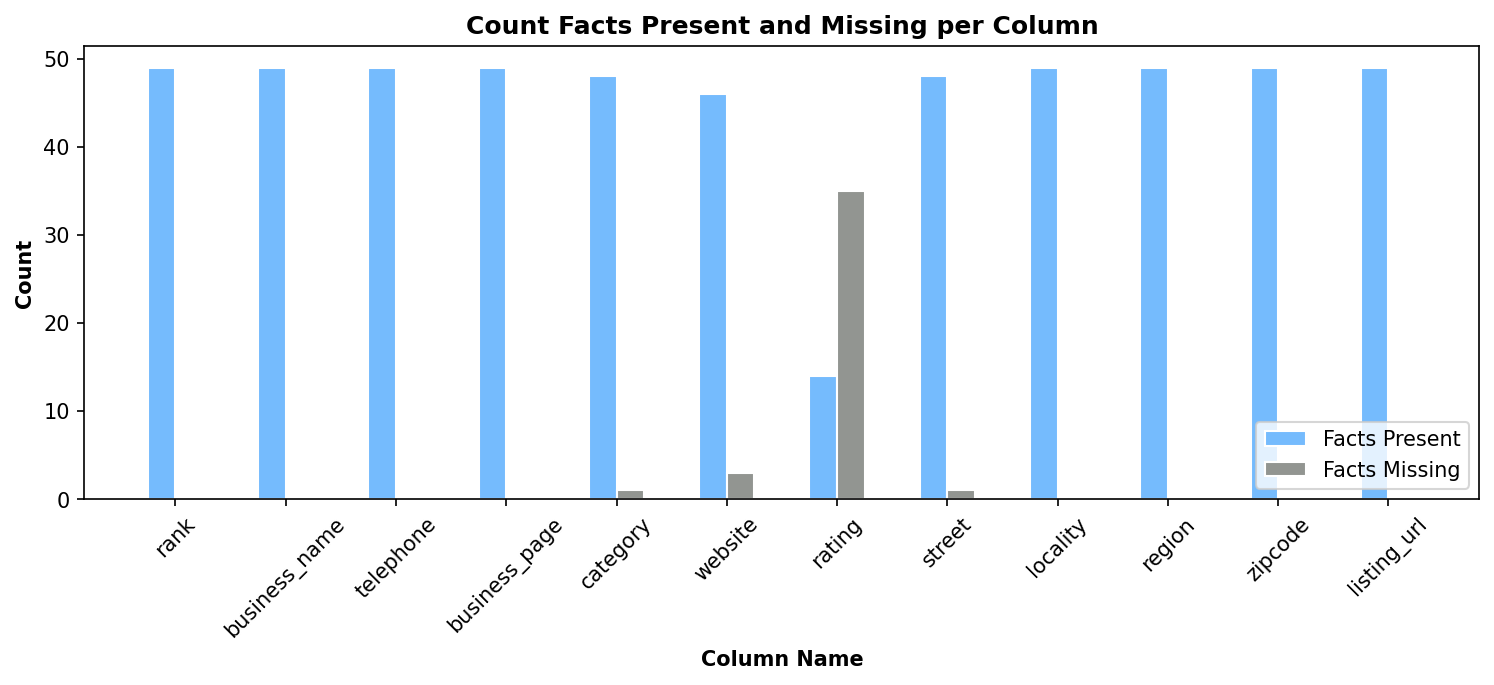

In [13]:
plot_present_missing(df_misos, 'count')

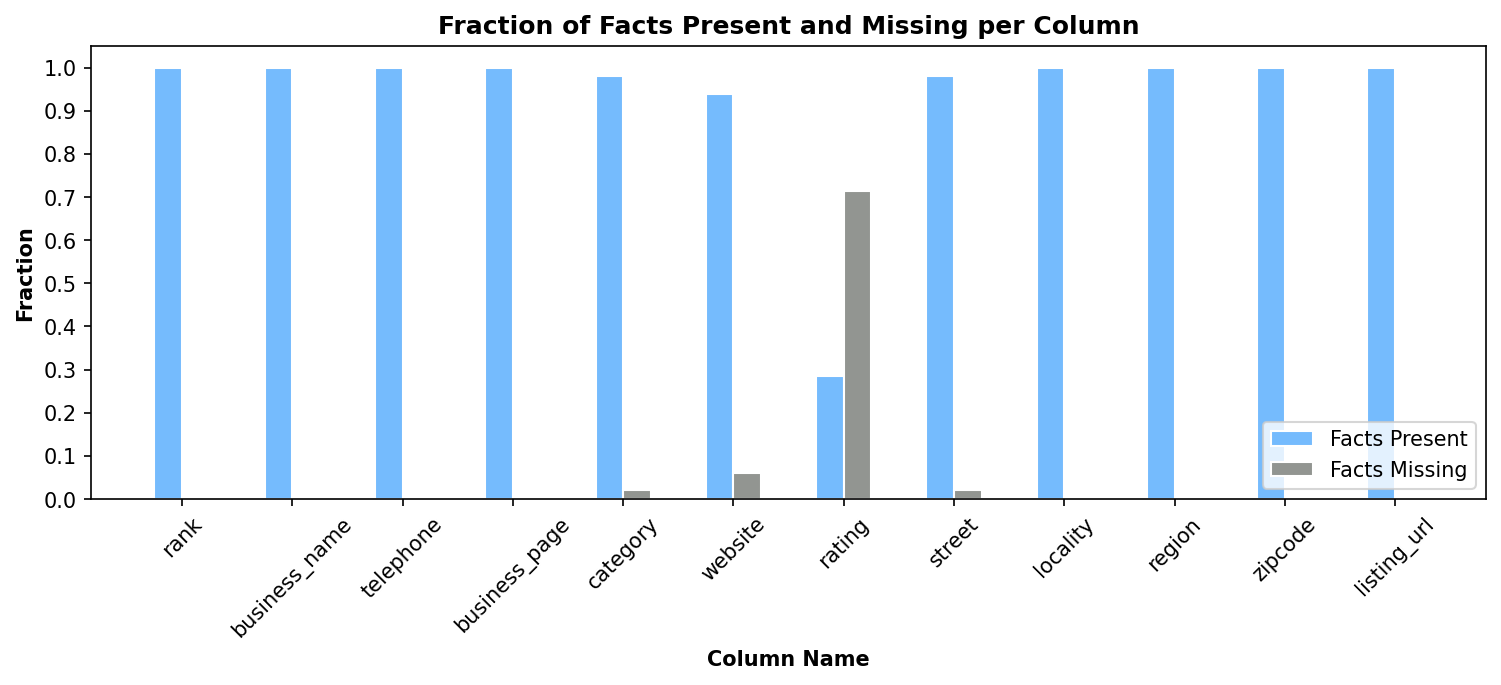

In [14]:
plot_present_missing(df_misos, 'fraction')

## How good are precision and recall?

### Load ground truth

In [15]:
df_misos_gt = pd.read_csv('./ground_truth/MISOS_Branches.csv')

In [122]:
df_misos_gt.head()

,name,address
0,Adrian,"1040 S Winter Ste 2200, Adrian, MI 49221"
1,Albion,"308 S Superior St, Albion, MI 49224"
2,Allegan,"430 Western Ave, Allegan, MI 49010"
3,Alma,"1586 Wright Ave, Alma, MI 48801"
4,Alpena,"2666 US 23 South, Alpena, MI 49707"


### Load test data

In [123]:
path_misos_yp = './yellowpages/state+of+michigan+secretary+of+state+office-MI-yellowpages-scraped-data.csv'
df_misos = pd.read_csv(path_misos_yp)

In [121]:
df_misos.head()

,rank,business_name,telephone,business_page,category,website,rating,street,locality,region,zipcode,listing_url
0,1.0,Michigan Secretary Of State Branch Office,(888) 767-6424,https://www.yellowpages.com/sparta-mi/mip/mich...,State Government,http://www.michigan.gov,2.0,534 S State St,Sparta,MI,49345,https://www.yellowpages.com/search?search_term...
1,2.0,State of Michigan Secretary of State Branch Of...,(888) 767-6424,https://www.yellowpages.com/adrian-mi/mip/stat...,State Government,http://expresssos.com,NaN,1040 S Winter St,Adrian,MI,49221,https://www.yellowpages.com/search?search_term...
2,3.0,"Michigan Department of State, Secretary of State",(888) 767-6424,https://www.yellowpages.com/brighton-mi/mip/mi...,Government Offices,NaN,NaN,9864 E Grand River Ste 130,Brighton,MI,48116,https://www.yellowpages.com/search?search_term...
3,4.0,State of Michigan Secretary of State Branch,(888) 767-6424,https://www.yellowpages.com/munising-mi/mip/st...,"State Government,City, Village & Township Gove...",NaN,NaN,NaN,Munising,MI,49862,https://www.yellowpages.com/search?search_term...
4,5.0,Secretary of State office,(888) 767-6424,https://www.yellowpages.com/traverse-city-mi/m...,"State Government,Vehicle License & Registratio...",http://expresssos.com,NaN,1759 Barlow St,Traverse City,MI,49686,https://www.yellowpages.com/search?search_term...


### Calculate precision and recall using Jaccard distances between address values

In [206]:
df_gt = df_misos_gt
df_test = df_misos
col_gt = 'address'
col_test = 'street'
jaccard_thresh = 0.84

precision = get_precision(df_test, df_gt, col_test, col_gt, jaccard_thresh)
recall = get_recall(df_test, df_gt, col_test, col_gt, jaccard_thresh)

print('Precision:\t', round(precision,2))
print('Recall:\t\t', round(recall,2))

Precision:	 0.82
Recall:		 0.37


### Check against precision and recall from hand-labeled data

In [165]:
df_misos_gt_labeled = pd.read_csv('./ground_truth/MISOS_Branches_labeled.csv')
path_misos_yp_labeled = './yellowpages/state+of+michigan+secretary+of+state+office-MI-yellowpages-scraped-data_labeled.csv'
df_misos_test_labeled = pd.read_csv(path_misos_yp_labeled)

precision = sum(df_misos_test_labeled.in_gt_data)/len(df_misos_test_labeled)
recall = sum(df_misos_gt_labeled.in_test_data)/len(df_misos_gt_labeled)

print('Precision:\t', round(precision,2))
print('Recall:\t\t', round(recall,2))

Precision:	 0.84
Recall:		 0.32


**Observation:** Precision and recall using Jaccard distances between address values is quite cloes to precision and recall from hand-labeled data.

## Are quantities reasonable?
- Statistical quality measures of errors. Here:
    - zipcodes should be five digits long
    - city names should be fewer than 30 characters
    - telephone values should contain a phonenumber detectable by the phonenumbers library.

Since we don't know what quantities a user might look for and check, it would be necessary to create a suite of custom tools for every type of quantity imaginable, or at least the ones that might see a lot of use.

### Example reasonableness checking tools:

**Usage:**
- "Here's a function specifically for checking how many potentially-legitimate e.g. city names are in your column which you think has city names."

**Inputs:**
- dataframe df which contains the table to assess
- string column_name which is the name of the column which the user wants to check for reasonableness

In [170]:
def check_zipcodes(df, column_name):
    if (df[column_name] > 99999).any():
        return "Illegitimate zipcodes exist."
    else:
        return "All zipcodes are legitimate."

In [171]:
def check_city_names(df, column_name):
    if len(df[df[column_name].str.len() > 30]) > 0:
        return "Illegitimate city names exist."
    else:
        return "All city names are legitimate."

In [181]:
import phonenumbers
def check_phone(df, column_name):
    for ind in df.index:
        s = df[column_name][ind]
        phone_list = []
        for match in phonenumbers.PhoneNumberMatcher(s,"US"):
            format_match = phonenumbers.format_number(match.number, phonenumbers.PhoneNumberFormat.E164)
            phone_list.append(str(format_match))
        if len(phone_list) != 1:
            return "Illegitimate phone numbers exist."
    return "All phone numbers are legitimate."

In [156]:
check_zipcodes(df_misos, 'zipcode')

'All zipcodes are legitimate.'

In [169]:
check_city_names(df_misos, 'locality')

'All city names are legitimate.'

In [182]:
check_phone(df_misos, 'telephone')

'All phone numbers are legitimate.'

# Demo 2: US National Parks

Ground truth source:
https://www.nps.gov/aboutus/national-park-system.htm

## Load data from wikidata

Data sourced from Wikidata using the API built by our team.

In [193]:
df_wikidata = pd.read_csv('./wikidata/national_parks_sparql.csv')
df_wikidata.head()

,Entity ID,entity_subclass_P31,entity_subclass_P31Label,Country_P17,Country_P17Label,Lon_Lat_P625,Inception_P571
0,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q836264,Kobuk Valley National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-159.283333333 67.55),1980-12-02T00:00:00Z
1,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q205952,Hawaiʻi Volcanoes National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-155.12361 19.40083),1916-01-01T00:00:00Z
2,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q841503,Kenai Fjords National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-150.10857 59.81571),1980-01-01T00:00:00Z
3,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q866080,Biscayne National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-80.18096924 25.50185493),1980-06-28T00:00:00Z
4,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q305880,Black Canyon of the Gunnison National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-107.716666666 38.566666666),1933-03-02T00:00:00Z


## What facts are available / missing?

num_rows: 77
num_columns: 7
column_names: ['Entity ID', 'entity_subclass_P31', 'entity_subclass_P31Label', 'Country_P17', 'Country_P17Label', 'Lon_Lat_P625', 'Inception_P571']


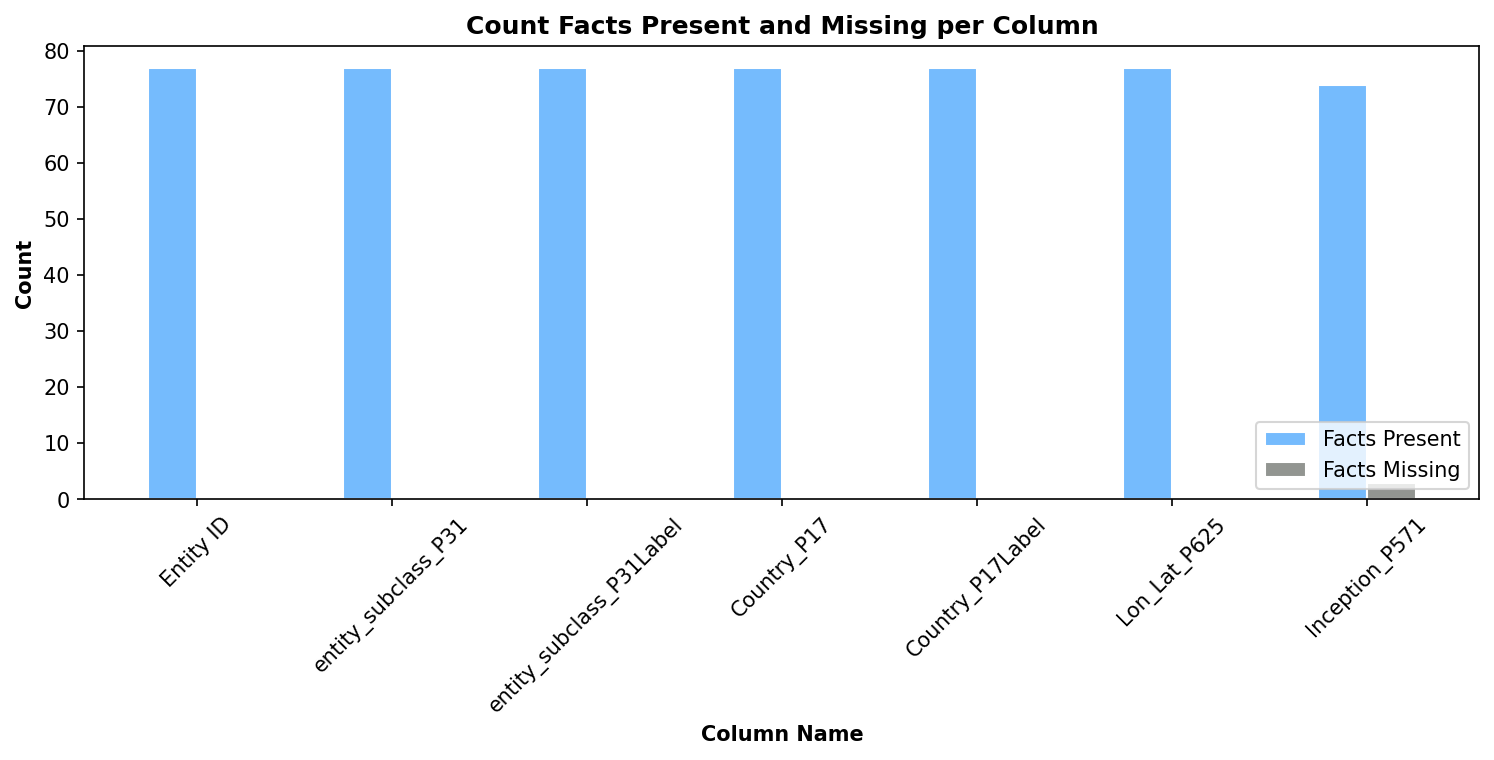

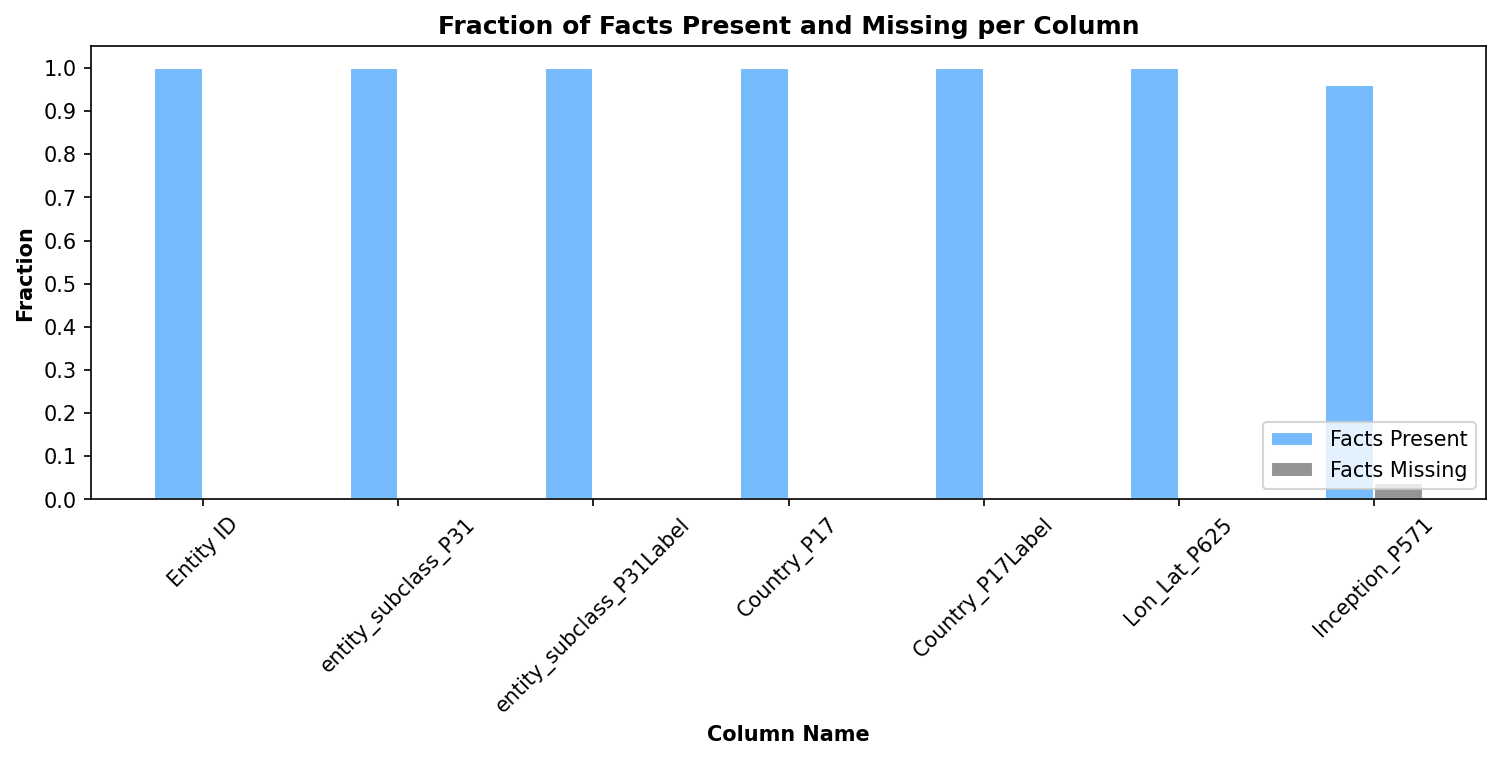

In [194]:
summarize_rows_columns(df_wikidata)
plot_present_missing(df_wikidata, 'count')
plot_present_missing(df_wikidata, 'fraction')

## How good are precision and recall?

### Load ground truth

In [207]:
df_gt = pd.read_csv('./ground_truth/national_parks.csv')

In [208]:
df_gt

,name,state
0,Acadia National Park,Maine
1,Arches National Park,Utah
2,Badlands National Park,South Dakota
3,Big Bend National Park,Texas
4,Biscayne National Park,Florida
...,...,...
57,Wind Cave National Park,South Dakota
58,Wrangell-St. Elias National Park,Alaska
59,Yellowstone National Park,"Idaho, Montana, and Wyoming"
60,Yosemite National Park,California


### Calculate precision and recall using Jaccard distances between address values

In [212]:
df_gt = df_gt
df_test = df_wikidata
col_gt = 'name'
col_test = 'entity_subclass_P31Label'
jaccard_thresh = 0.3

precision = get_precision(df_test, df_gt, col_test, col_gt, jaccard_thresh)
recall = get_recall(df_test, df_gt, col_test, col_gt, jaccard_thresh)

print('Precision:\t', round(precision,2))
print('Recall:\t\t', round(recall,2))

Precision:	 0.91
Recall:		 0.94


### Check against precision and recall from hand-labeled data


In [215]:
df_gt = pd.read_csv('./ground_truth/national_parks_labeled.csv')
df_test = pd.read_csv('./wikidata/national_parks_sparql_labeled.csv')

precision = sum(df_test.in_gt_data)/len(df_test)
recall = sum(df_gt.in_test_data)/len(df_gt)

print('Precision:\t', round(precision,2))
print('Recall:\t\t', round(recall,2))

Precision:	 0.97
Recall:		 1.0


**Observation:** Precision and recall using Jaccard distances between address values is quite cloes to precision and recall from hand-labeled data.

In [220]:
max(df_gt.name.str.len())

42

In [224]:
def check_park_names(df, column_name):
    if len(df[df[column_name].str.len() > 50]) > 0:
        return "Illegitimate park names exist."
    else:
        return "All park names are legitimate."

In [225]:
check_park_names(df_wikidata, 'entity_subclass_P31Label')

'All park names are legitimate.'